In [2]:
#import main libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# pip install seaborn
import seaborn as sns
# roc curve and auc score
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score,f1_score,fbeta_score,plot_precision_recall_curve,plot_roc_curve
from sklearn.metrics import auc,cohen_kappa_score,confusion_matrix,ConfusionMatrixDisplay

# Graphics in retina format are more sharp and legible

from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [16]:
#import libraries for making a pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.compose import make_column_selector
from sklearn.model_selection import cross_val_score

### Modify the pipeline to remove multi-collinearity for linear models

In [10]:
#import data to dataframe
df = pd.read_csv("datasets/BankChurners.csv")
#drop last 2 columns as not required
df.drop(labels={'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'},axis=1,inplace = True)
df.shape#(10127, 21)

(10127, 21)

In [11]:
#create numerical target var
df['Attrition_Flag']=df['Attrition_Flag'].apply(lambda x: 0 if x=='Existing Customer' else 1)
df_copy=df.copy()
df_copy['Attrition_Flag'].value_counts()

0    8500
1    1627
Name: Attrition_Flag, dtype: int64

##Build a Pipeline for the following order
- impute values(missing or outlier)
- encode variabes (categorical-onehot, ordinal - ordinal)
- feature creation 
- Find correlation between vars(Using EDA step-1)

In [12]:
df_copy=df_copy.drop('CLIENTNUM',axis=1)
df_copy.shape

(10127, 20)

In [15]:
#cnvert all categorical datatype as category
cat_collist=[         
#'Months_Inactive_12_mon',  #consider the var as numeric
#'Contacts_Count_12_mon',   #consider the var as numeric
'Total_Relationship_Count',  
'Gender',                   
'Dependent_count',          
'Marital_Status',            
'Card_Category']
ord_collist=['Education_Level',        
'Income_Category']
df_copy[cat_collist] = df_copy[cat_collist].astype('category')

In [17]:
#convert ordinal data using Ordinalencoder as it is diffcult to use in pipeline

df_copy[['Education_Level']] = OrdinalEncoder(categories=
               [['Unknown','Uneducated','High School','Graduate','College','Post-Graduate','Doctorate']]).fit_transform(df_copy[['Education_Level']])
df_copy[['Income_Category']] = OrdinalEncoder(categories=
               [['Unknown','Less than $40K','$40K - $60K','$60K - $80K','$80K - $120K','$120K +']]).fit_transform(df_copy[['Income_Category']])

df_copy.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,M,3,2.0,Married,3.0,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,F,5,3.0,Single,1.0,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,M,3,3.0,Married,4.0,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,F,4,2.0,Unknown,1.0,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,M,3,1.0,Married,3.0,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [18]:
#Feature pipeline here
#based on univariate DA

df_copy['MOB_lbl'] = pd.cut(df_copy['Months_on_book'], bins=[0, 24, 36, float('Inf')], 
                              labels=['<=24', '24-36', '>36'],include_lowest = True)
df_copy['Ina_12_cnt_lbl'] = pd.cut(df_copy['Months_Inactive_12_mon'], bins=[0, 3, float('Inf')],
                                     labels=['<=3', '>3'],include_lowest = True)
df_copy['Credit_Limit_lbl'] = pd.cut(df_copy['Credit_Limit'], bins=[0, 5000, 10000,15000,30000,float('Inf')], 
                                       labels=['0-5k', '5-10k','10-15k','15-30k','>30k'],include_lowest = True)
df_copy['util_lbl'] = pd.cut(df_copy['Avg_Utilization_Ratio'], bins=[0, 0.2,0.5, float('Inf')], 
                                       labels=['0-0.2','0.2-0.5','>0.5'],include_lowest = True)
df_copy['Trans_Amt_lbl'] = pd.cut(df_copy['Total_Trans_Amt'], bins=[0, 5000, 12500, float('Inf')], 
                                       labels=['0-5k','5-12.5k','>12.5k'],include_lowest = True)
df_copy['Trans_Ct_lbl'] = pd.cut(df_copy['Total_Trans_Ct'], bins=[0, 50,100, float('Inf')], 
                                       labels=['0-50','50-100','>100'],include_lowest = True)

<AxesSubplot:>

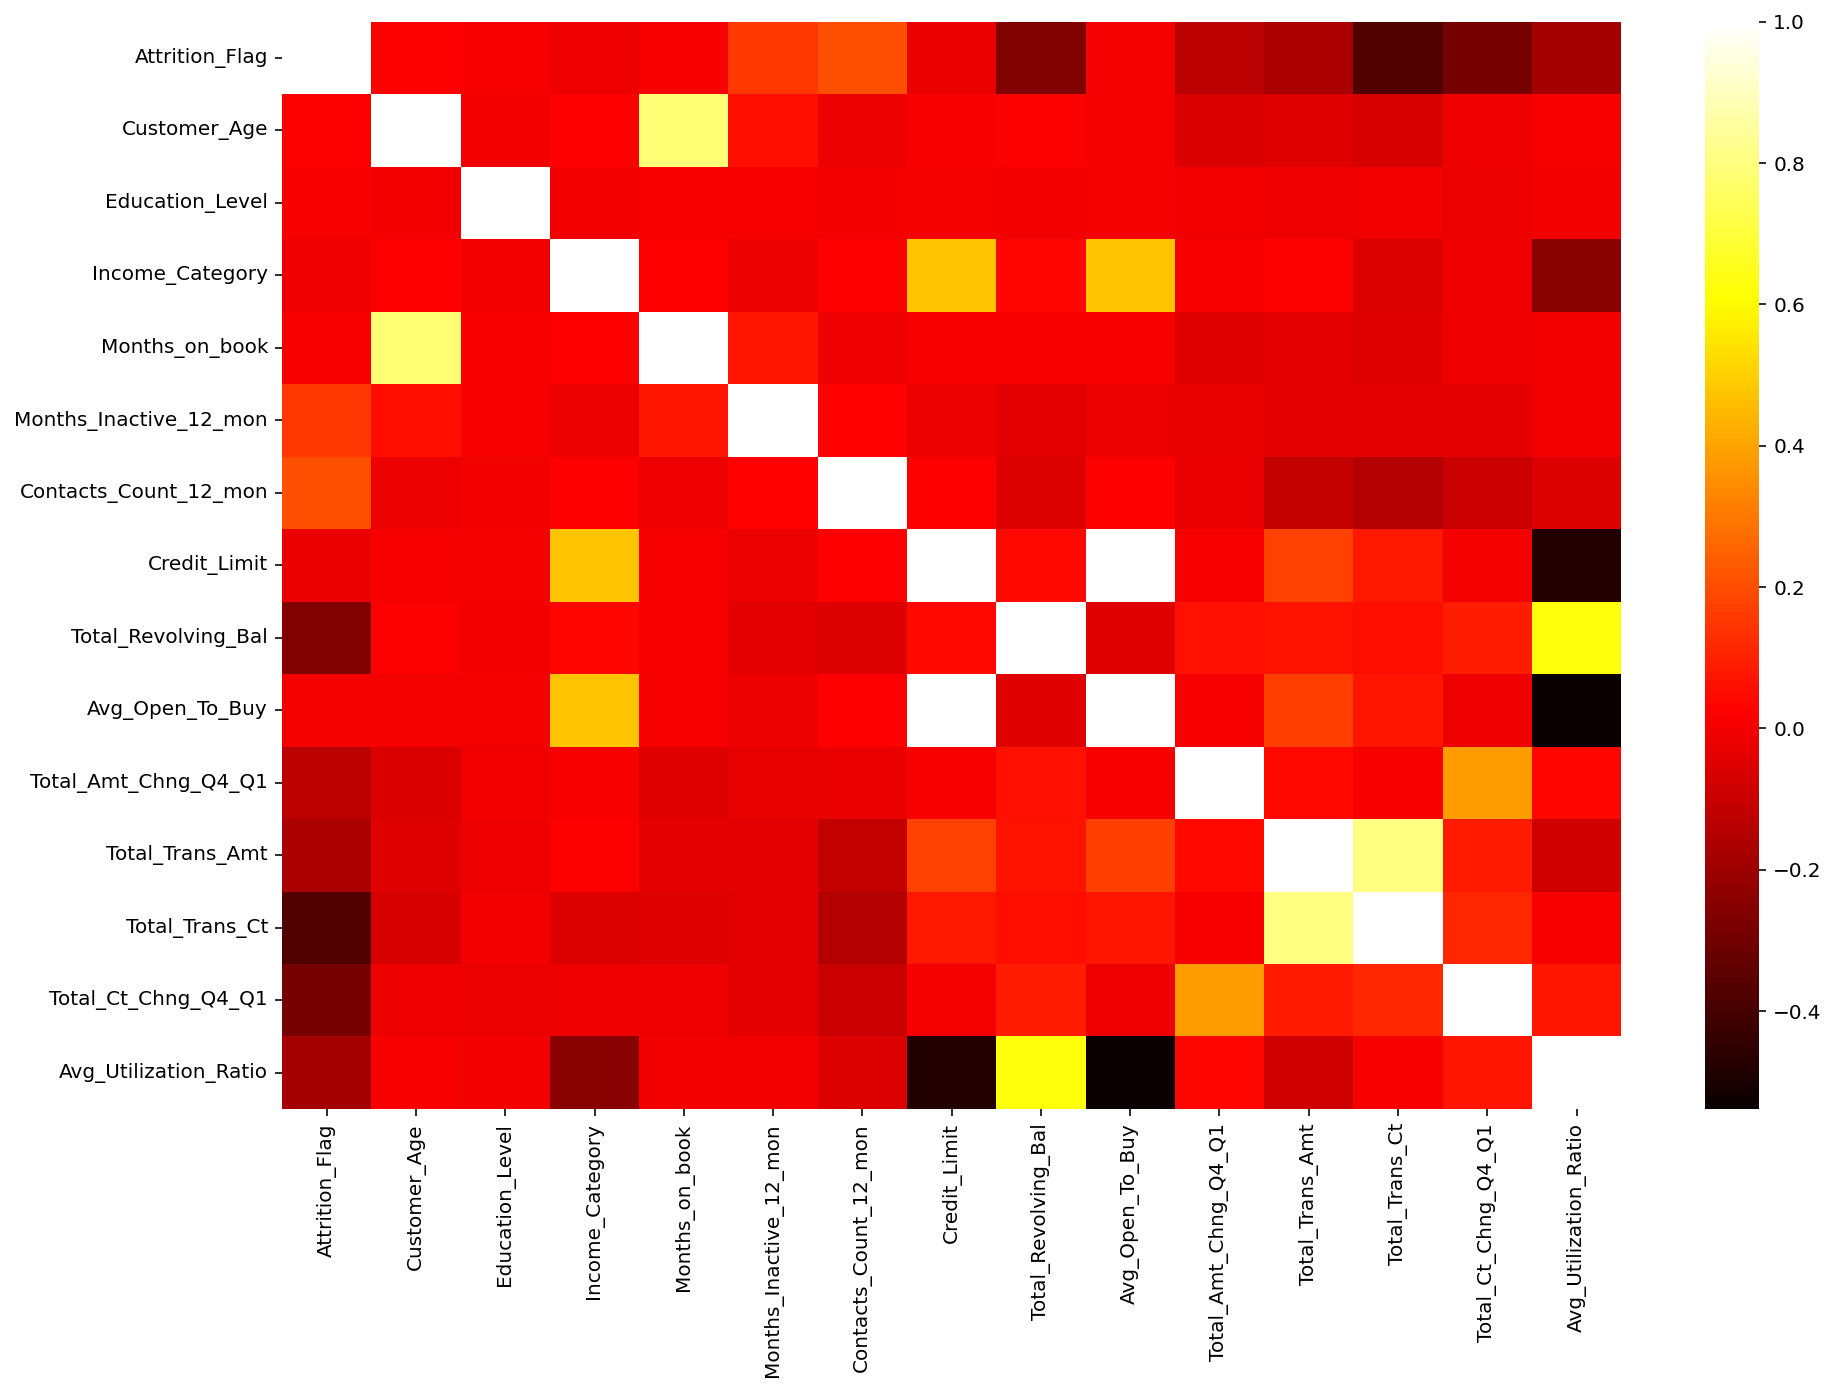

In [19]:
#heatmap of correlation matrix
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(df_copy.corr(),cmap='hot')

# Collinear Variables:-
       +ve
- cust Age vs MOB
- Rev bal vs Utilisation Ratio
- Tot Amt change Q4/Q1 vs Total count change Q4/Q1
- Tot Tran Amt vs Tot Tran Cnt
- Credit Limit vs Open to buy
       -ve
- Tran Cnt vs Tot relationship count
- Tran Amt vs Tot Relationship count
- Credit limit vs Utilisation
- Avg open to buy Vs utilisation

In [20]:
#drop list of collinear vars
drop_collinear=['Customer_Age','Avg_Utilization_Ratio','Total_Amt_Chng_Q4_Q1',
                'Total_Trans_Ct','Avg_Open_To_Buy']
df_copy = df_copy.drop(columns= drop_collinear,axis=1)
df_copy

,Attrition_Flag,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Credit_Limit,Total_Revolving_Bal,Total_Trans_Amt,Total_Ct_Chng_Q4_Q1,MOB_lbl,Ina_12_cnt_lbl,Credit_Limit_lbl,util_lbl,Trans_Amt_lbl,Trans_Ct_lbl
0,0,M,3,2.0,Married,3.0,Blue,39,5,1,...,12691.0,777,1144,1.625,>36,<=3,10-15k,0-0.2,0-5k,0-50
1,0,F,5,3.0,Single,1.0,Blue,44,6,1,...,8256.0,864,1291,3.714,>36,<=3,5-10k,0-0.2,0-5k,0-50
2,0,M,3,3.0,Married,4.0,Blue,36,4,1,...,3418.0,0,1887,2.333,24-36,<=3,0-5k,0-0.2,0-5k,0-50
3,0,F,4,2.0,Unknown,1.0,Blue,34,3,4,...,3313.0,2517,1171,2.333,24-36,>3,0-5k,>0.5,0-5k,0-50
4,0,M,3,1.0,Married,3.0,Blue,21,5,1,...,4716.0,0,816,2.500,<=24,<=3,0-5k,0-0.2,0-5k,0-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0,M,2,3.0,Single,2.0,Blue,40,3,2,...,4003.0,1851,15476,0.857,>36,<=3,0-5k,0.2-0.5,>12.5k,>100
10123,1,M,2,0.0,Divorced,2.0,Blue,25,4,2,...,4277.0,2186,8764,0.683,24-36,<=3,0-5k,>0.5,5-12.5k,50-100
10124,1,F,1,2.0,Married,1.0,Blue,36,5,3,...,5409.0,0,10291,0.818,24-36,<=3,5-10k,0-0.2,5-12.5k,50-100
10125,1,M,2,3.0,Unknown,2.0,Blue,36,4,3,...,5281.0,0,8395,0.722,24-36,<=3,5-10k,0-0.2,5-12.5k,50-100


<AxesSubplot:>

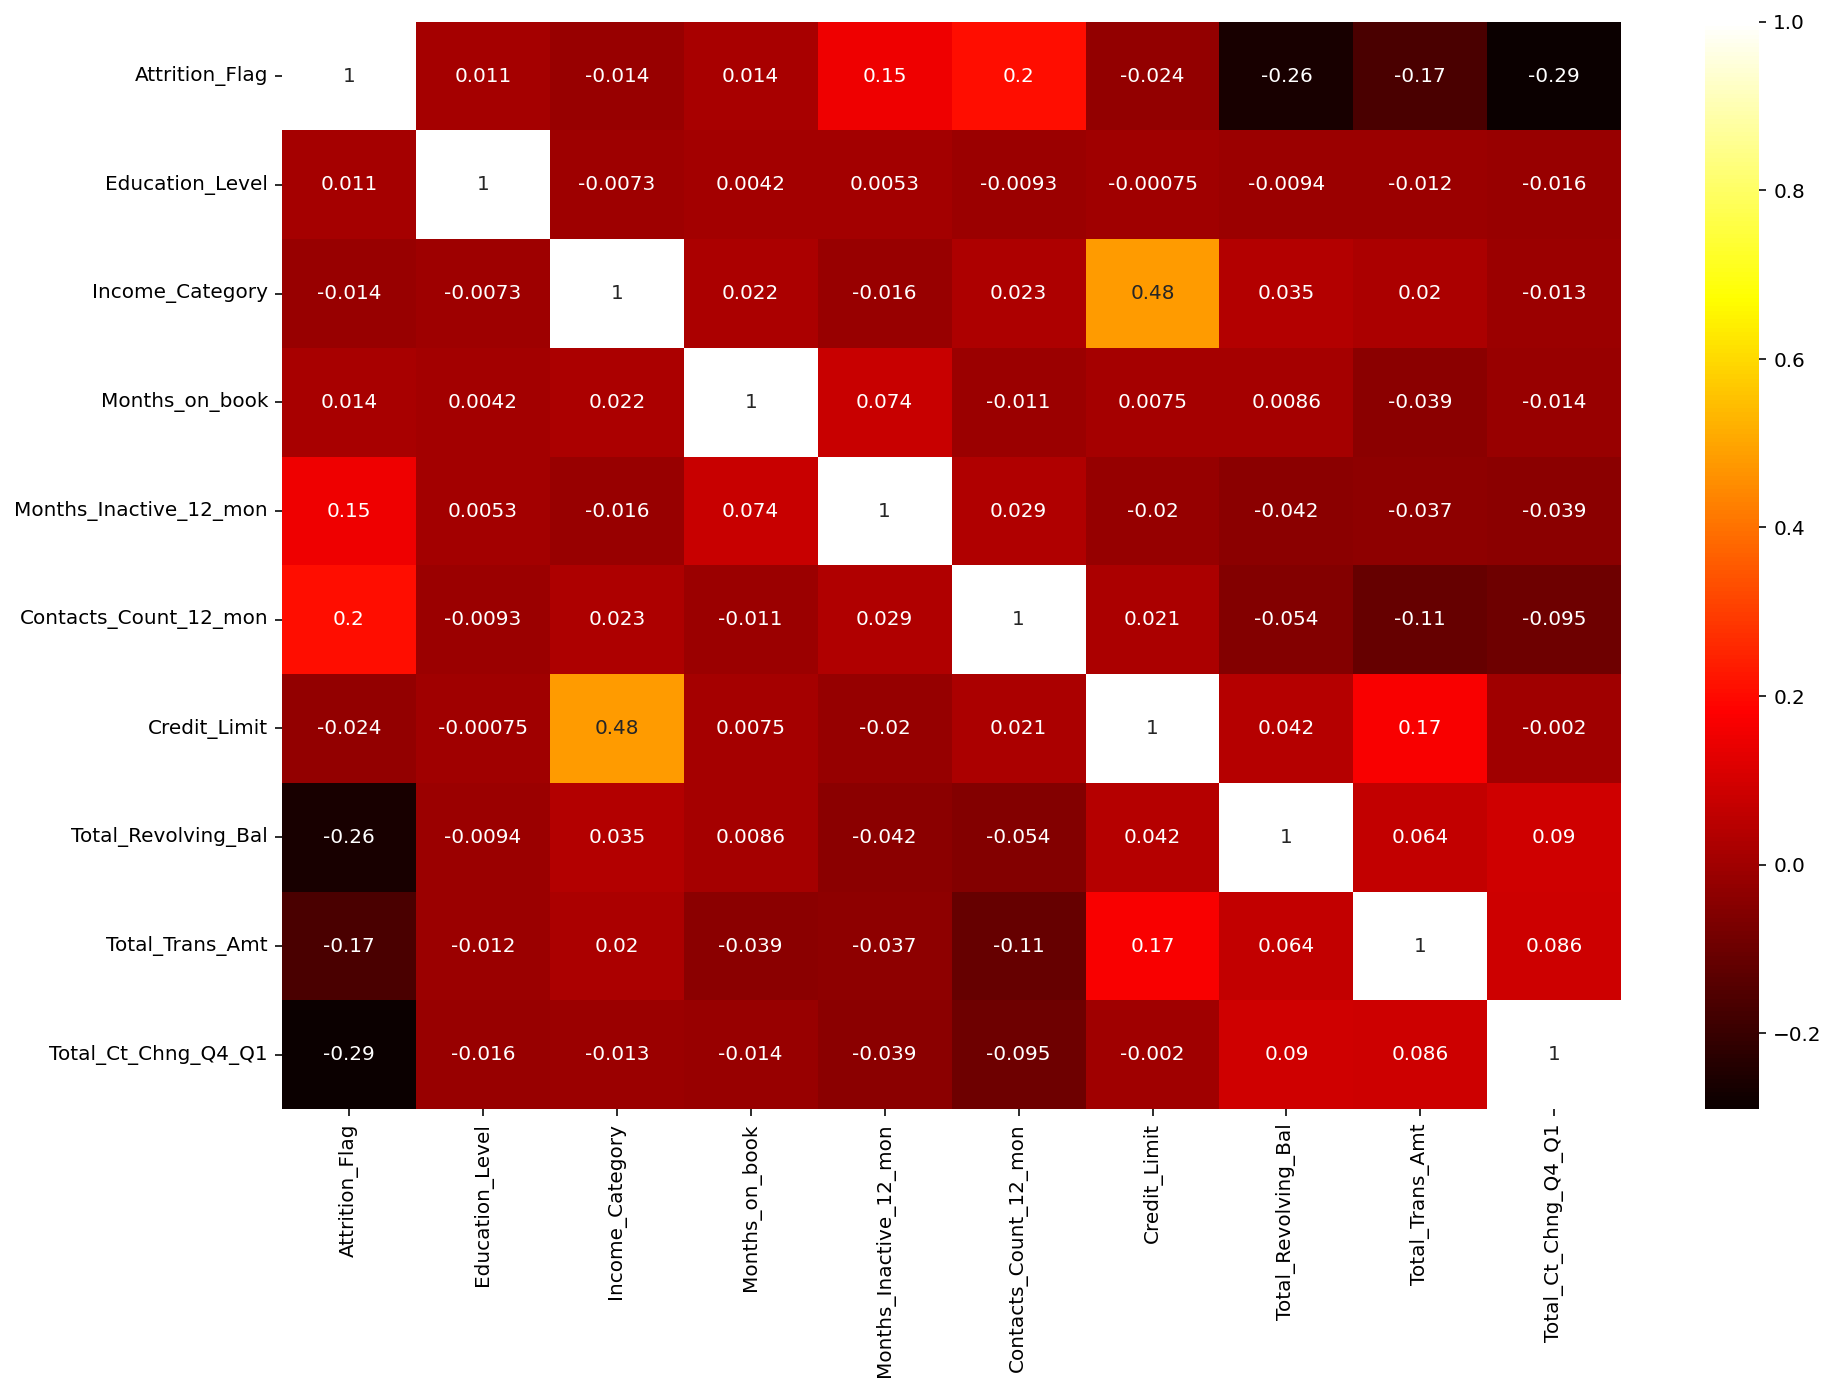

In [22]:
#heatmap of correlation matrix
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(df_copy.corr(),annot=True,cmap='hot')
#income category vs credit limit

In [24]:
#drop income category
df_copy = df_copy.drop('Income_Category',axis=1)

<AxesSubplot:>

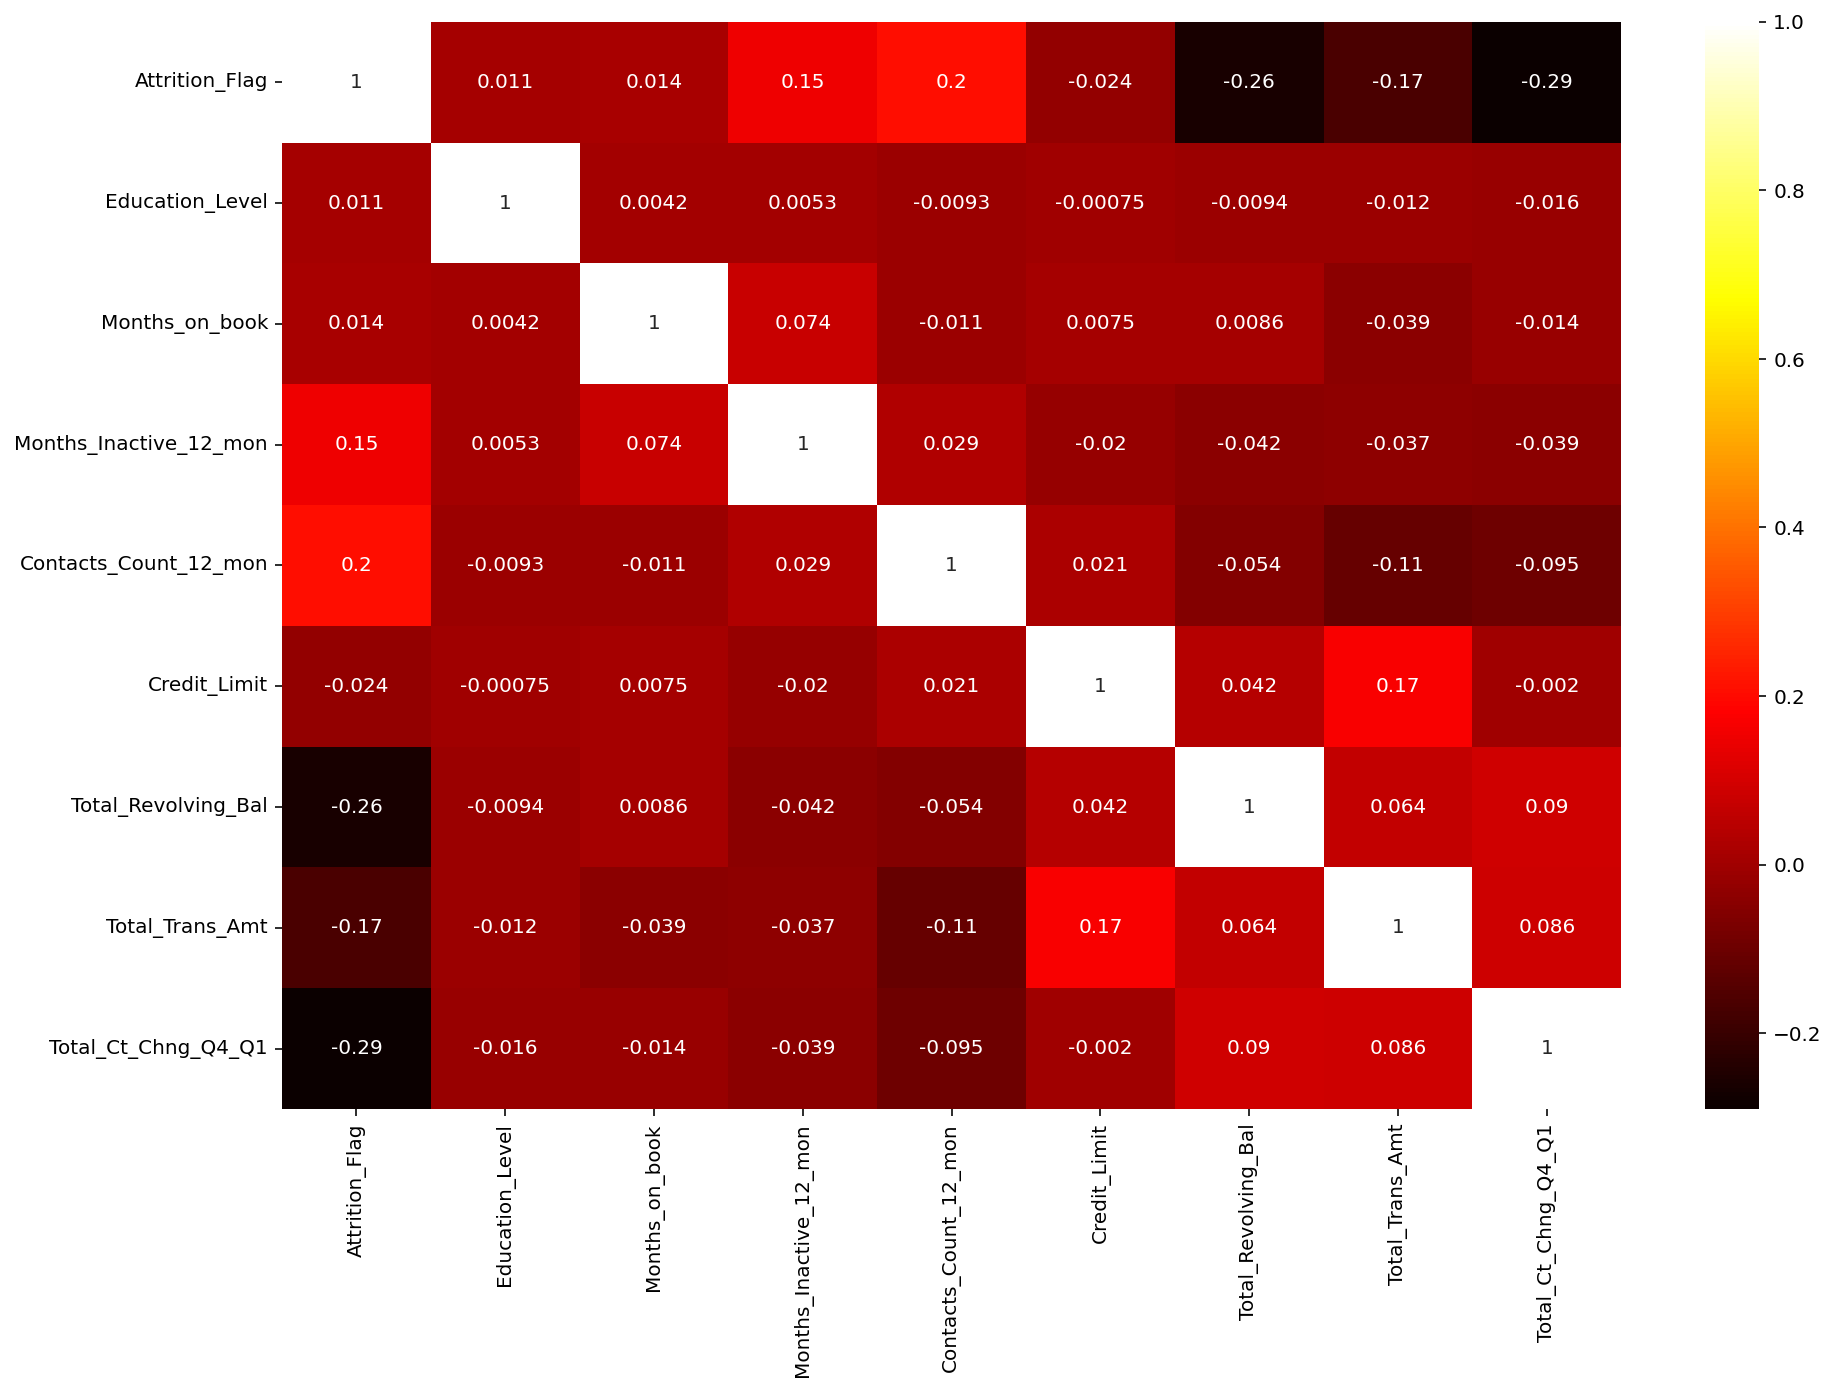

In [25]:
#heatmap of correlation matrix
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(df_copy.corr(),annot=True,cmap='hot')
#income category vs credit limit

# PIPELINE START

# Encoding categorical /Numerical data
- Ordinal encoder converts ordinal column to discrete Numeric values (rank order). Output is single column
- OneHotEncoder converts 1 caegorical column to "number of categories(n-level)" columns. drop='first' removes 1st column to avoid collinearity in model(dummy variable trap). 
- Numerical values can be converted to categorical (bins) - equal sized ranges (eg:-deciles) or equally distributed data ranges(each bin contains equal number of values). We can also manually create categorical bins based on business knowledge or observation from EDA step

In [30]:
#create test and train data
df_train_data,df_test_data,df_train_target,df_test_target = train_test_split(df_copy.drop('Attrition_Flag',axis=1),df_copy['Attrition_Flag'],test_size=0.3,
                                                                           random_state=42,stratify=df_copy['Attrition_Flag'])
print(df_train_data.shape,' and ',df_test_data.shape)
#(7088, 19)  and  (3039, 19)

(7088, 19)  and  (3039, 19)


In [26]:
cat_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(sparse=False,handle_unknown='ignore',drop='first'))
])

In [27]:
#numerical transformer for numerical data
Num_trf = Pipeline([
    ('scale',MinMaxScaler())
])

In [28]:
trf1 = ColumnTransformer([
        ("pass", "passthrough", make_column_selector(dtype_exclude="category")),
        ("cat", cat_pipeline, make_column_selector(dtype_include="category"))
])

In [29]:
# 4) Feature selection
trf2 = SelectKBest(score_func=chi2,k=10)

In [31]:
df_new=pd.DataFrame(trf1.fit_transform(df_train_data),columns=trf1.get_feature_names_out())
df_new
#38 cols

,pass__Education_Level,pass__Months_on_book,pass__Months_Inactive_12_mon,pass__Contacts_Count_12_mon,pass__Credit_Limit,pass__Total_Revolving_Bal,pass__Total_Trans_Amt,pass__Total_Ct_Chng_Q4_Q1,cat__Gender_M,cat__Dependent_count_1,...,cat__Credit_Limit_lbl_10-15k,cat__Credit_Limit_lbl_15-30k,cat__Credit_Limit_lbl_5-10k,cat__Credit_Limit_lbl_>30k,cat__util_lbl_0.2-0.5,cat__util_lbl_>0.5,cat__Trans_Amt_lbl_5-12.5k,cat__Trans_Amt_lbl_>12.5k,cat__Trans_Ct_lbl_50-100,cat__Trans_Ct_lbl_>100
0,1.0,36.0,3.0,3.0,6680.0,1839.0,7632.0,0.532,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,3.0,34.0,1.0,1.0,2884.0,2517.0,4809.0,0.740,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,36.0,2.0,2.0,14858.0,1594.0,4286.0,0.636,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3.0,17.0,1.0,4.0,2638.0,2092.0,1868.0,0.344,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,6.0,36.0,1.0,2.0,8896.0,1338.0,4252.0,0.591,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7083,0.0,40.0,1.0,3.0,2950.0,2000.0,4742.0,0.837,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7084,2.0,30.0,1.0,3.0,5869.0,0.0,5103.0,0.844,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7085,2.0,35.0,3.0,3.0,1959.0,1022.0,7847.0,0.857,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
7086,4.0,26.0,2.0,2.0,3879.0,0.0,7786.0,0.929,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


<AxesSubplot:>

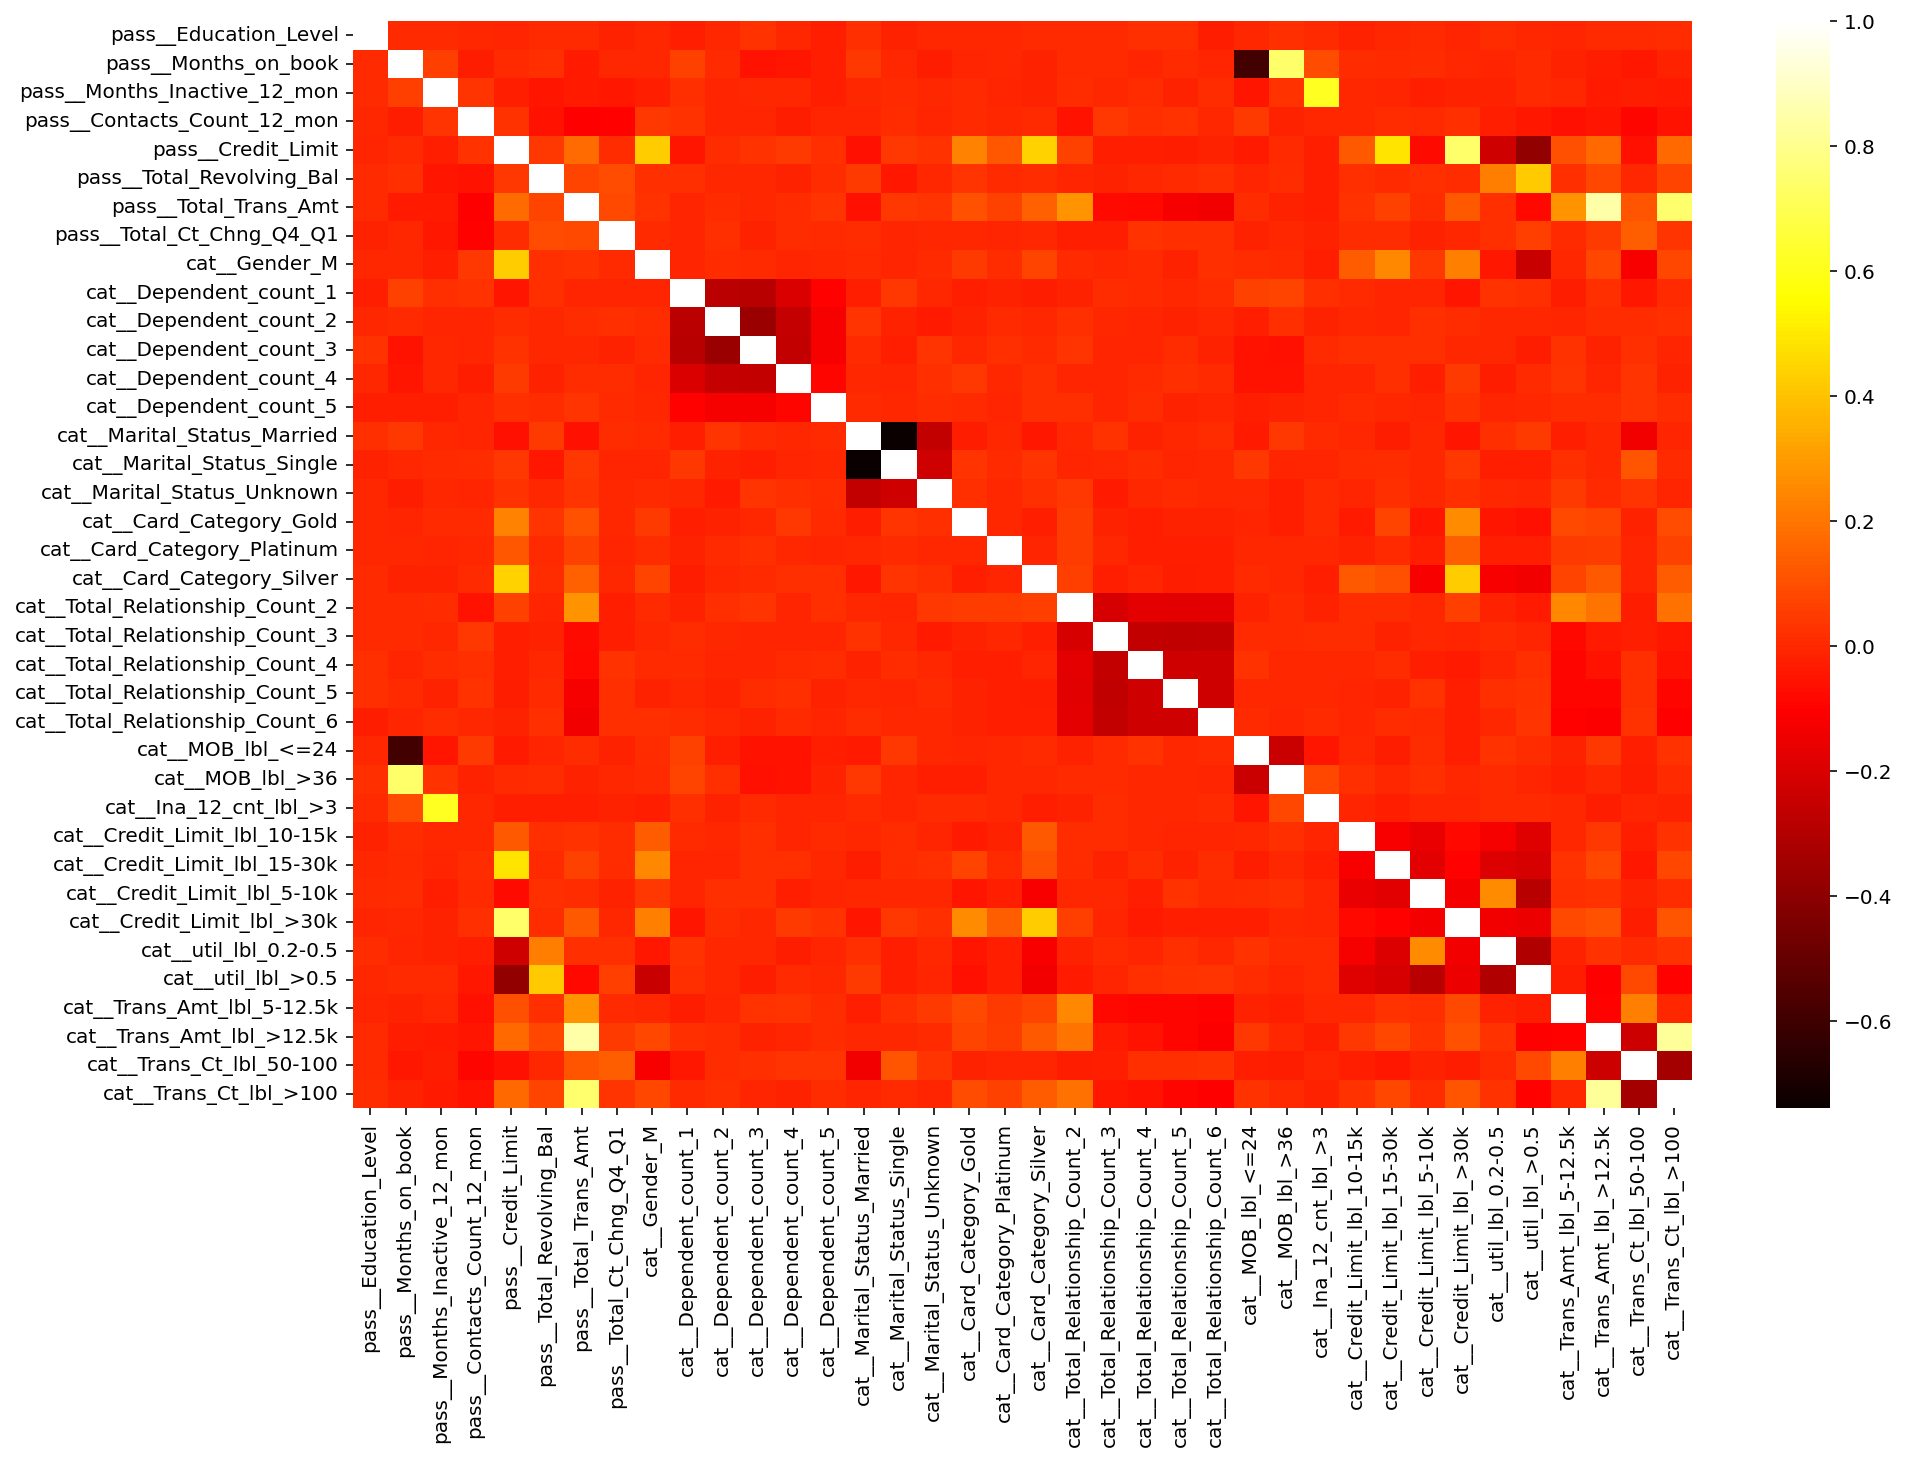

In [34]:
#heatmap of correlation matrix
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(df_new.corr(),cmap='hot')
#income category vs credit limit